# Übung 4

#### Vorüberlegungen
- We could measure the distance from the true point to the predicted point with the mean squared error. So the average of the squared differences between prediction and actual values.
$$L(x_0, y_0, f) = (f(x_0)-y_0)^2$$
with 
$$ f(x) = a_0 + a_1\cdot x^1 + a_2\cdot x^2 + \dots + a_d \cdot x^d

Um das Gradientenabstiegsverfahren für eine polynomiale Funktion $f$ d-ten Grades mit den Koeffizienten $a_0, a_1, ..., a_d$ und der Kostenfunktion des mittleren quadratischen Fehlers (MSE) zu implementieren, müssen wir die partiellen Ableitungen von $L(f)$, der MSE-Funktion, berechnen.

Die MSE-Funktion berechnet den durchschnittlichen quadratischen Fehler zwischen den Vorhersagewerten von $f$ und den tatsächlichen Werten $y$ der gegebenen Punkte $(x, y)$ in einem Intervall von $[0,1]$:

$$ L(f) = \frac{1}{n} \sum_{i=1}^{n} (f(x_i) - y_i)^2 $$

wobei $n$ die Anzahl der Punkte ist.

Die partielle Ableitung von $L(f)$ nach $a_i$ kann als Produktregel der Ableitung von $L(f)$ nach $f(x)$ und der Ableitung von $f(x)$ nach $a_i$ berechnet werden:

$$ \frac{\partial L(f)}{\partial a_i} = \frac{\partial L(f)}{\partial f(x)} \cdot \frac{\partial f(x)}{\partial a_i} $$

Die Ableitung von $L(f)$ nach $f(x)$ ist:

$$ \frac{\partial L(f)}{\partial f(x)} = \frac{2}{n} \sum_{i=1}^{n} (f(x_i) - y_i) $$

Die Ableitung von $f(x)$ nach $a_i$ ist einfach $x^i$. Daher ist die Ableitung von $L(f)$ nach $a_i$:

$$ \frac{\partial L(f)}{\partial a_i} = \frac{2}{n} \sum_{i=1}^{n} (f(x_i) - y_i) \cdot x_i^i $$

Dies ist die partielle Ableitung von $L(f)$ nach $a_i$, die wir für das Gradientenabstiegsverfahren benötigen.

Um das Gradientenabstiegsverfahren durchzuführen, müssen wir den Gradienten von $L(f)$ berechnen, um die Koeffizienten $a_0, a_1, ..., a_d$ schrittweise zu aktualisieren. Wir können die Koeffizienten mit der folgenden Formel aktualisieren:

$$ a_i = a_i - \alpha \frac{\partial L(f)}{\partial a_i} $$

wobei $\alpha$ die Lernrate ist, die bestimmt, wie schnell wir die Koeffizienten aktualisieren.

Das Gradientenabstiegsverfahren wird iterativ angewendet, bis der Wert von $L(f)$ nicht mehr signifikant abnimmt. Die Anzahl der Iterationen hängt von der Komplexität des Modells und der Genauigkeit der Ergebnisse ab.

#### Create a Dataset with n points and variable noise level

In [1]:
from typing import Callable
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display


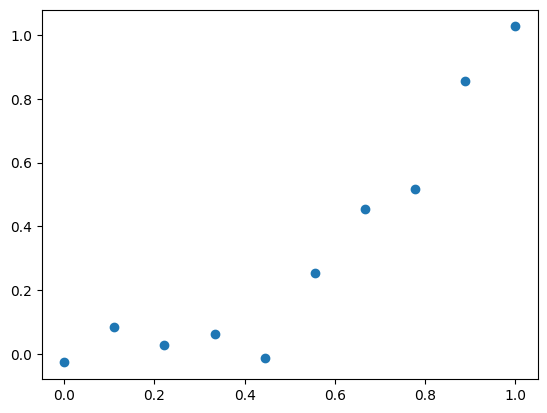

In [92]:
def generate_dataset(n: int, x_noise_level: float, y_noise_level: float) -> NDArray:
    rng = np.random.default_rng(42)
    x = np.linspace(0, 1, n) + rng.uniform(-1, 1, n) * x_noise_level
    y = np.hstack((0*x[x < 0.5], x[x >= 0.5]**2)) + rng.uniform(-1, 1, n) * y_noise_level
    return x, y

x, y = generate_dataset(10, 0, 0.1)
# plot the points
plt.scatter(x, y)
plt.show()

In [93]:
class MiniBatchGradientDescent():
    def __init__(
        self, 
        learning_rate: float, 
        batch_size: int, 
        max_epochs: int, 
        tolerance: float,
        target_function: Callable,
        degree: int
        ):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.max_epochs = max_epochs
        self.tolerance = tolerance
        self.target_function = target_function
        self.degree = degree
        self.rng = np.random.default_rng(42)
        
    def iterate_minibatches(self, inputs, targets, batchsize, shuffle=False):
        assert len(inputs) == len(targets)
        if shuffle:
            indices = np.random.permutation(len(inputs))
        else:
            indices = np.arange(len(inputs))
        for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
            if shuffle:
                excerpt = indices[start_idx:start_idx + batchsize]
            else:
                excerpt = slice(start_idx, start_idx + batchsize)
            yield inputs[excerpt], targets[excerpt]
    
    def fit(self, x: NDArray, y: NDArray) -> None:
        self.x, self.y = x, y
        # initialize weights randomly
        self.a_values = self.rng.standard_normal(self.degree + 1)    
        self.losses = []
        self.epoch_loss = []
        
        for _ in range(self.max_epochs):
    
            indices = self.rng.permutation(len(x))
            x, y = self.x[indices], self.y[indices]
            
            for batch in self.iterate_minibatches(x, y, self.batch_size):
                
                x_batch, y_batch = batch
                batch_loss = np.zeros(self.batch_size)
                batch_gradient = np.zeros(self.batch_size)
                
                for idx in range(self.batch_size):
                    y_hat = self.predict(x_batch[idx])
                    batch_loss[idx] = 0.5 * (y_hat - y_batch[idx]) ** 2
                    batch_gradient[idx] = np.mean([(y_hat - y_batch[idx]) * x_batch[idx] ** d for d in range(self.degree + 1)])

                gradient = batch_gradient.mean()
                self.update_parameters(gradient)
                self.losses.append(batch_loss)
                
                if self.is_converged(batch_loss):
                    self.epoch_loss.append(batch_loss.mean())
                    break
                
            self.epoch_loss.append(batch_loss.mean())
         
               
    def is_converged(self, loss: float) -> bool:
        converged = False
        # check last 10 elements for convergence
        if len(self.losses) > 10:
            if np.std(self.losses[-10:]) < self.tolerance:
                converged = True
        return converged

    def calculate_loss(self, x: NDArray, y: NDArray) -> float:
        return (self.predict(x) - y)**2
    
    def calculate_gradient(self, x: NDArray, y: NDArray) -> NDArray:
        return 2 * (self.predict(x) - y) * x
        
    def update_parameters(self, gradient: float | NDArray) -> float | NDArray:
        self.a_values -= gradient * self.learning_rate
    
    def get_training_loss(self) -> float:
        return self.losses[-1]
    
    def predict(self, x: float | NDArray) -> float | NDArray:
        return self.target_function(self.a_values, x)
    
    def plot(self) -> float:
        # combine plot_fit  and plot_loss into subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        # plot the points
        ax1.plot(self.x, self.y, color="blue", label="training data")
        ax1.scatter(self.x, self.y, color="blue", marker="+")
        # plot the function
        x = np.linspace(0, 1, 100)
        # y = np.polyval(self.a_values, x)
        ax1.plot(self.x, self.predict(self.x), color="red", label="fit mini batch")
        ax1.legend()
        ax1.set_xlabel("x")
        ax1.set_ylabel("y")
        ax1.set_title(f"Gradient descent with function {self.target_function.__name__}\nof degree {self.degree}")
        # plot the loss
        ax2.plot(self.epoch_loss)
        ax2.set_xlabel("epoch")
        ax2.set_ylabel("loss")
        ax2.set_title(f"Loss over epochs for degree {self.degree}")
        plt.show()

        return self.get_training_loss()

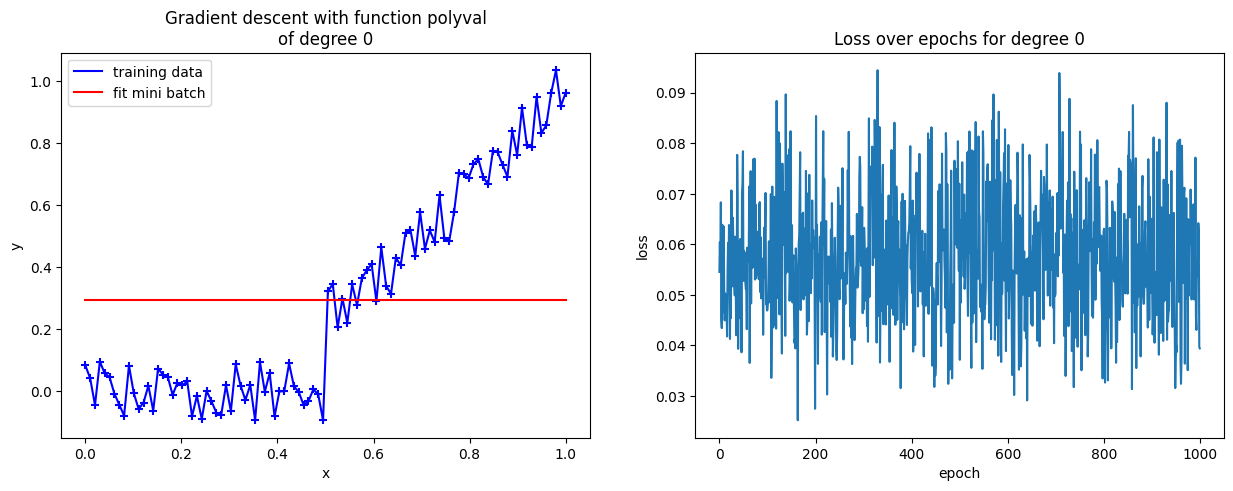

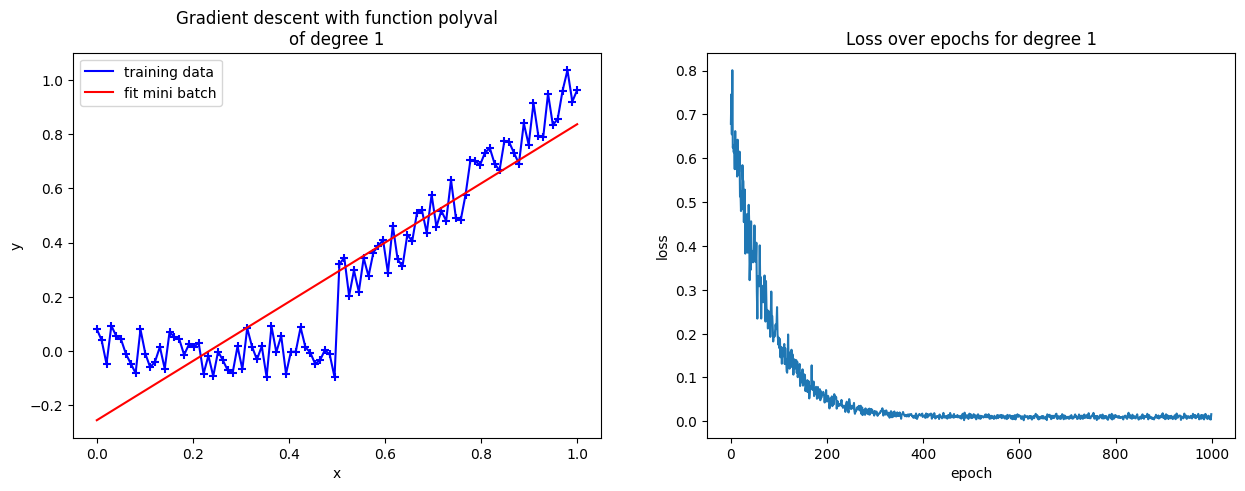

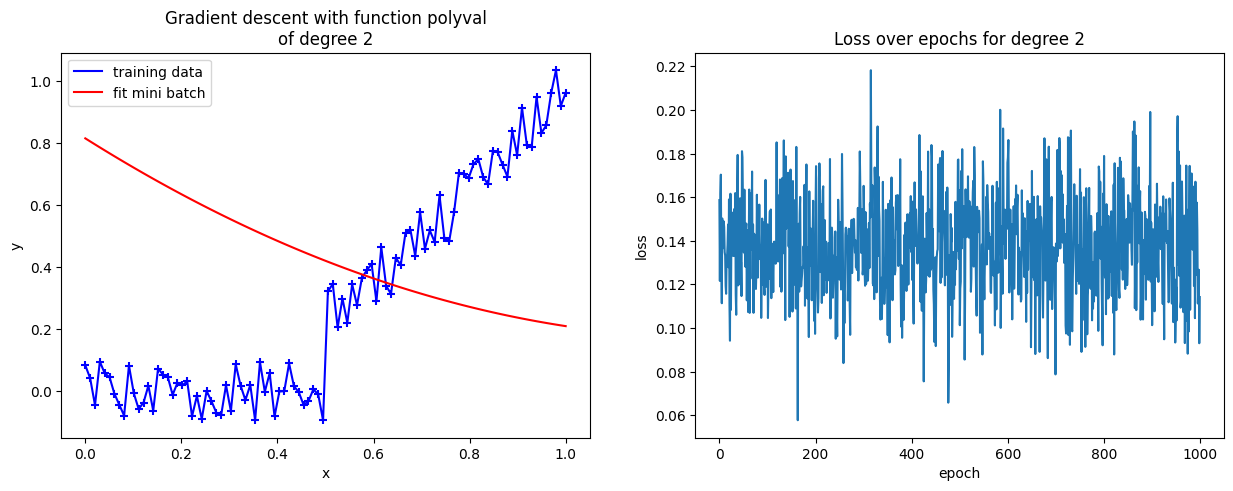

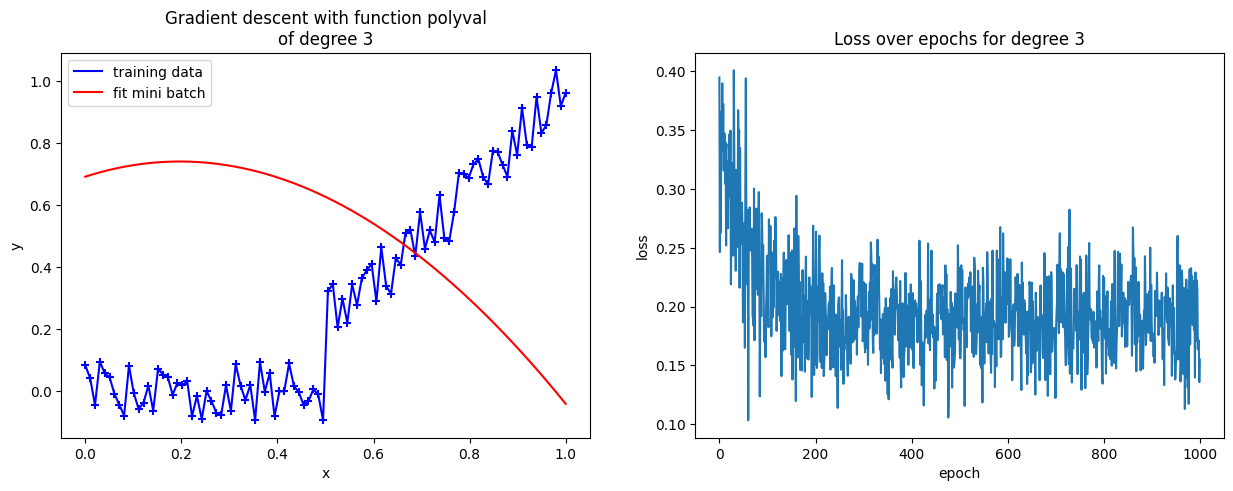

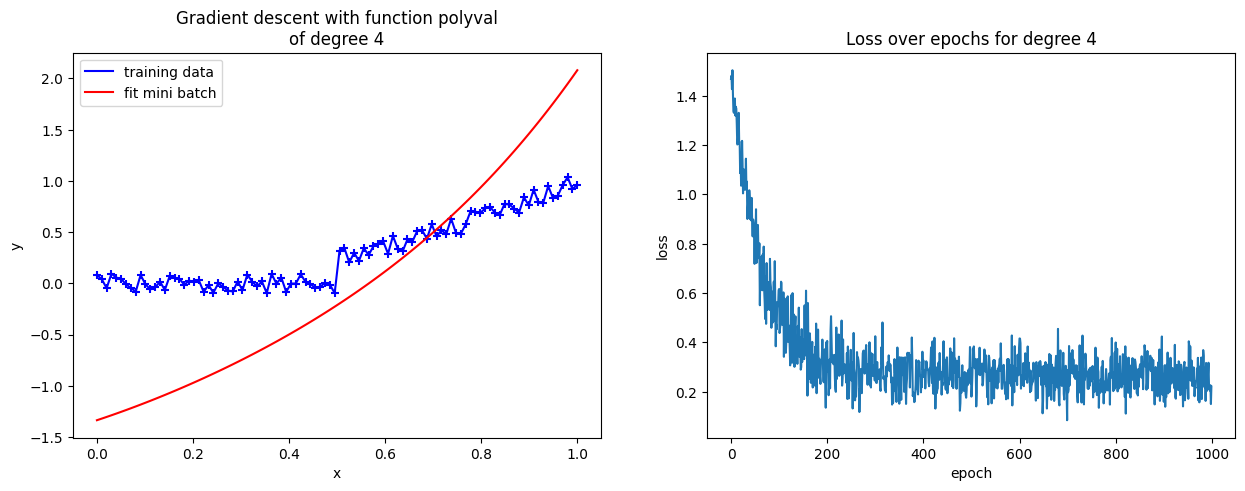

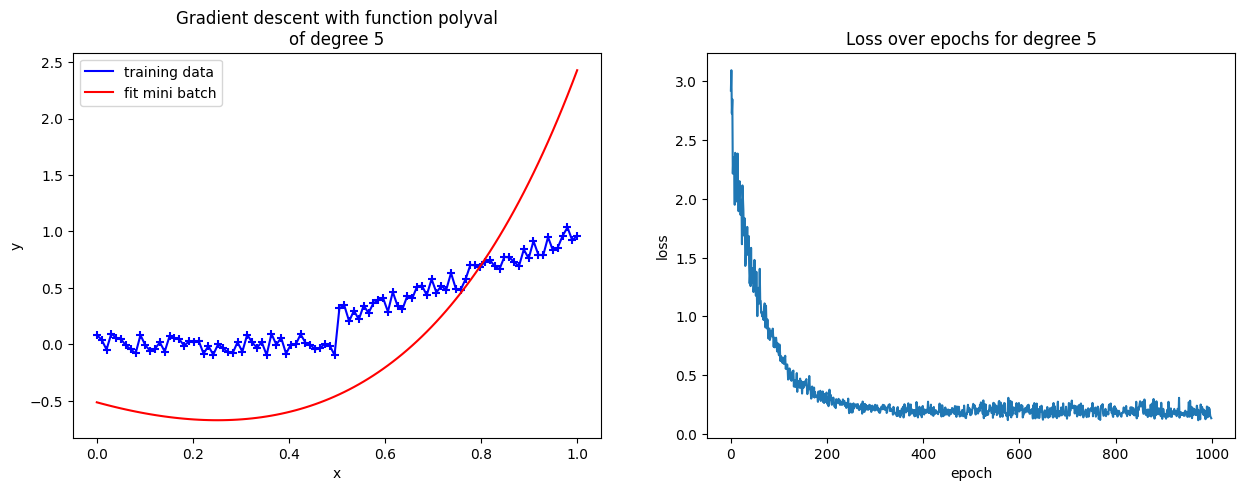

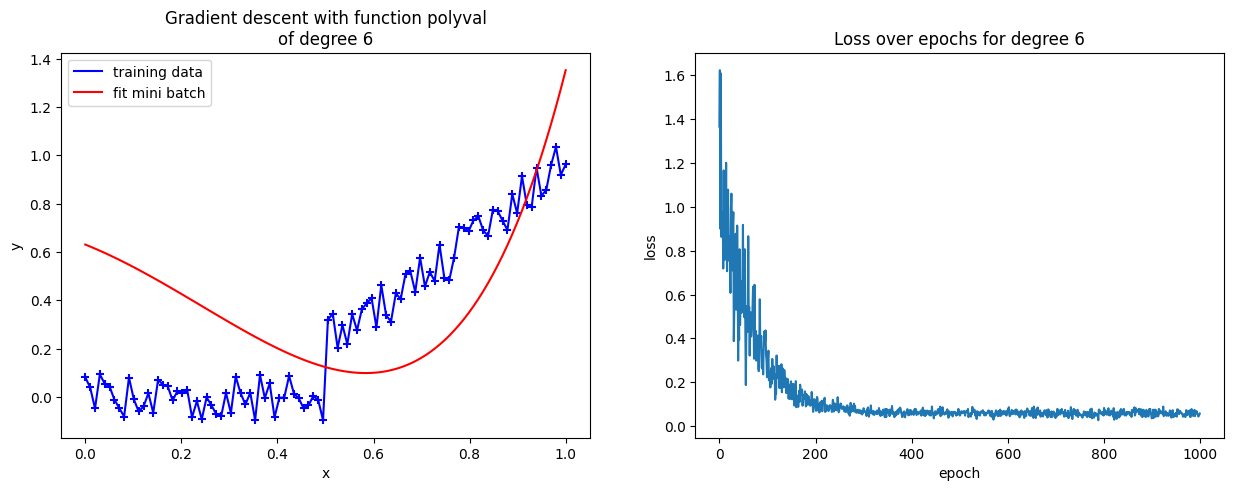

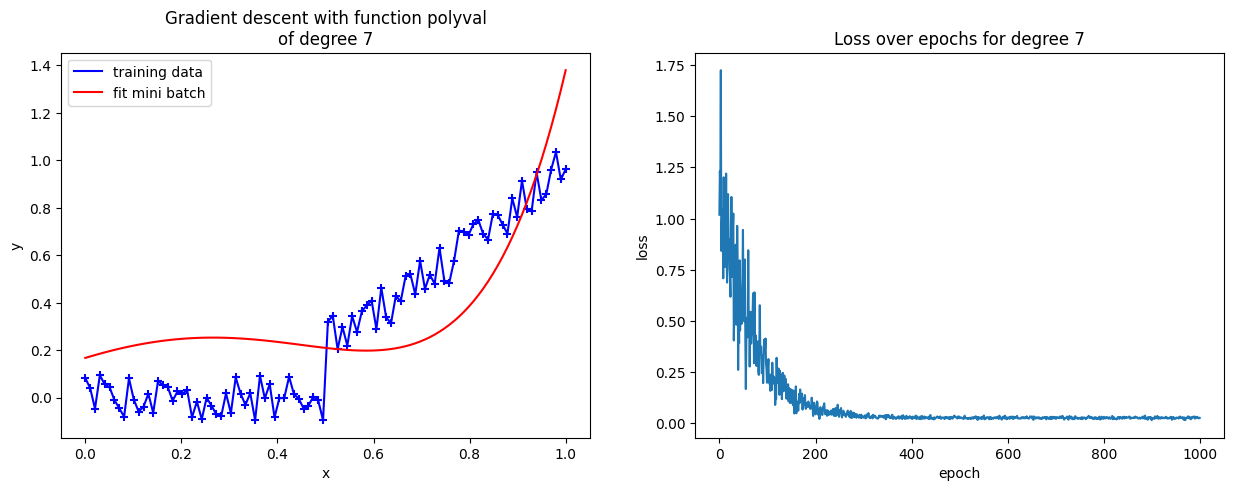

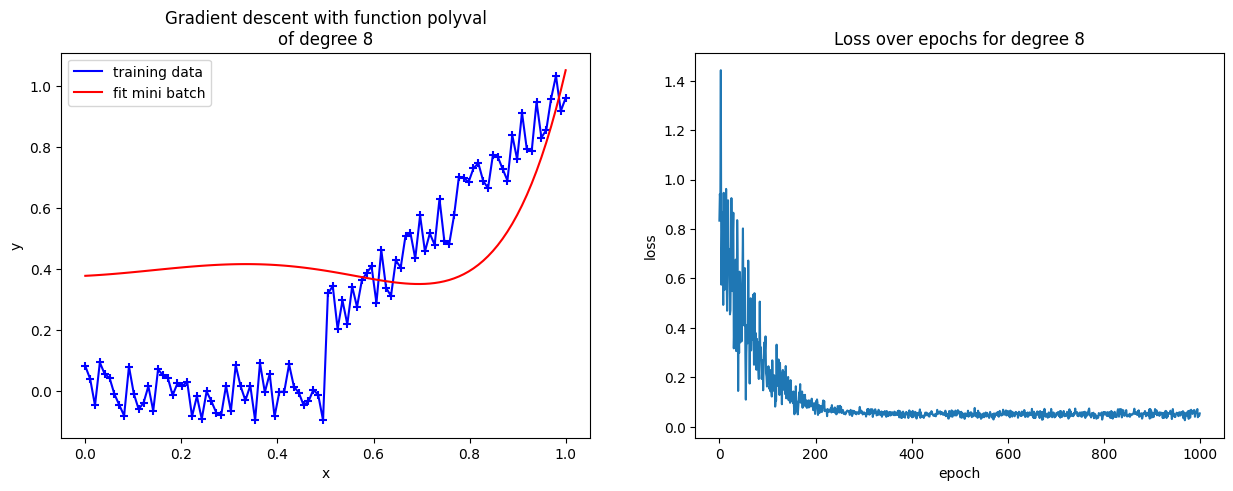

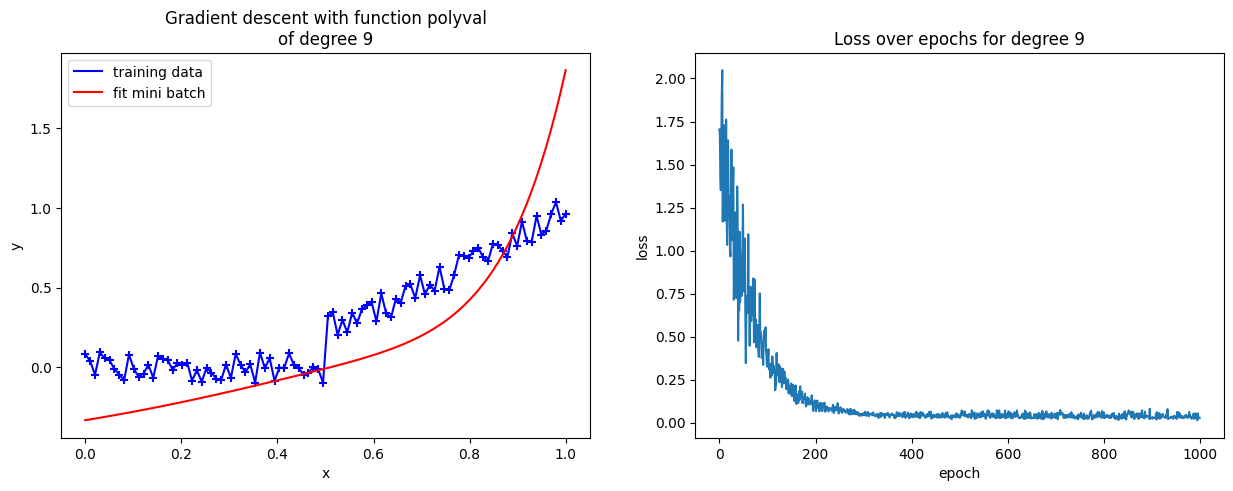

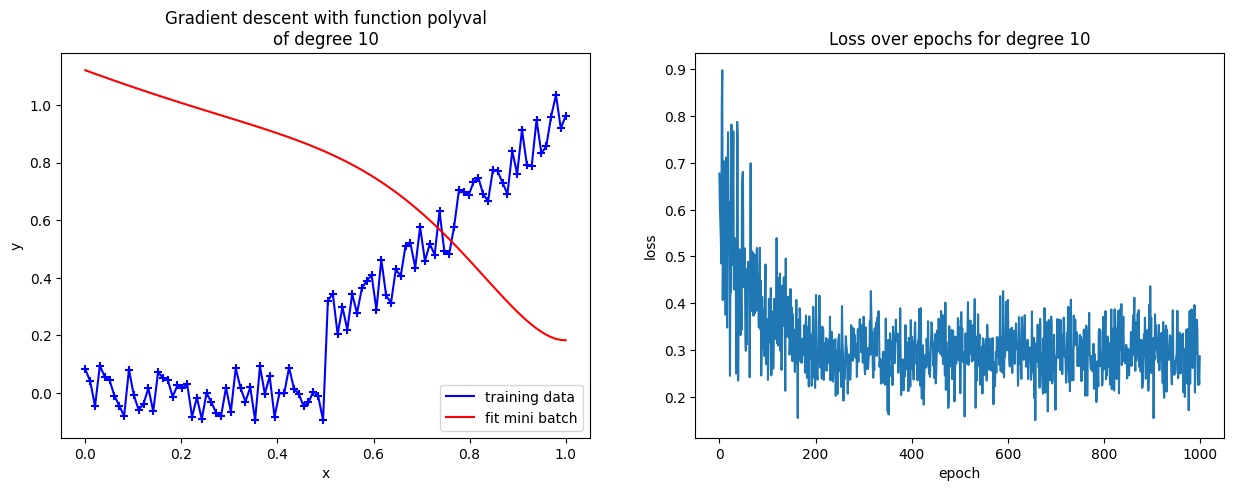

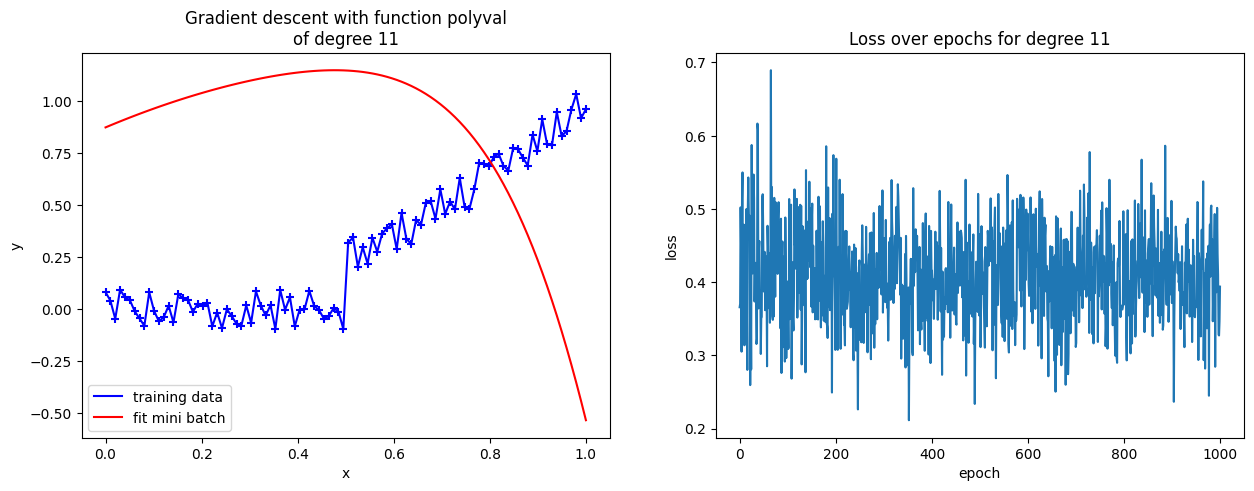

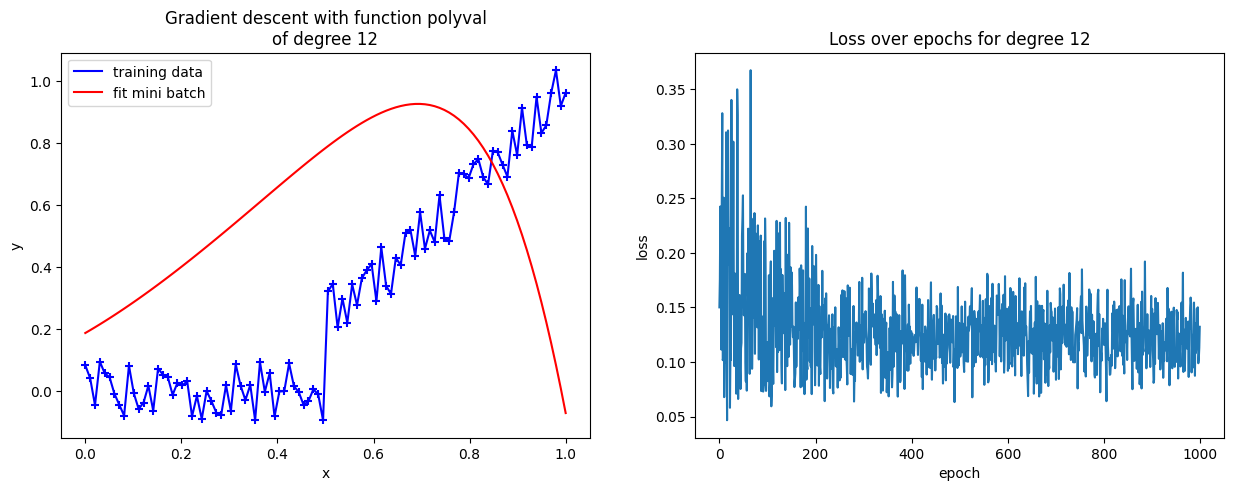

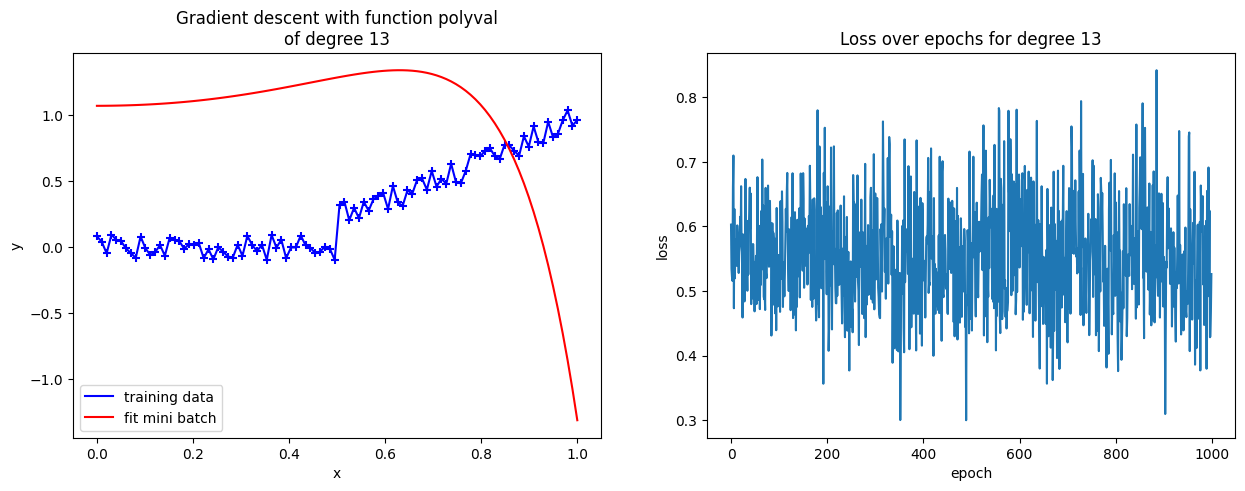

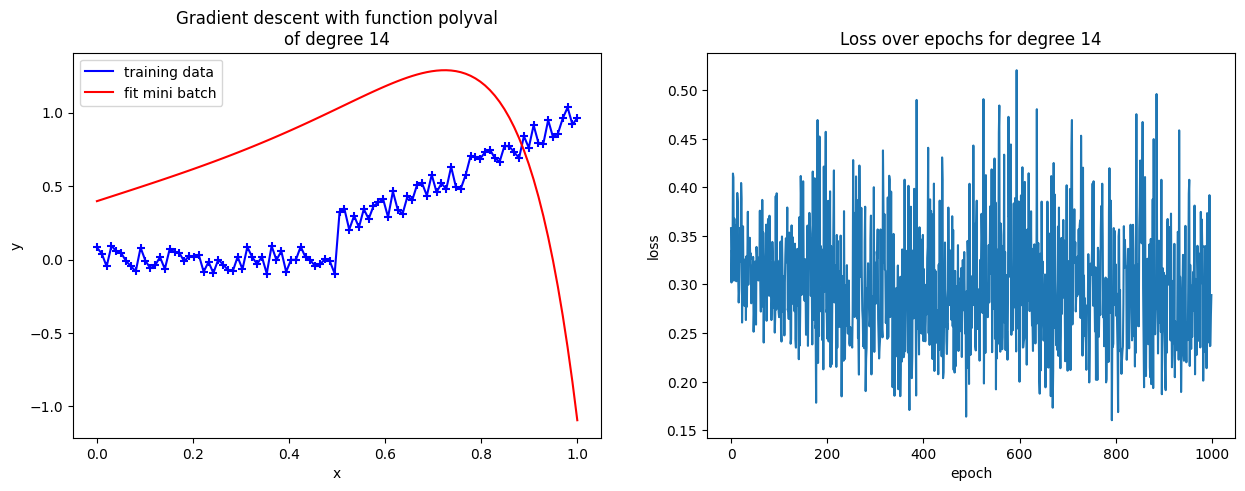

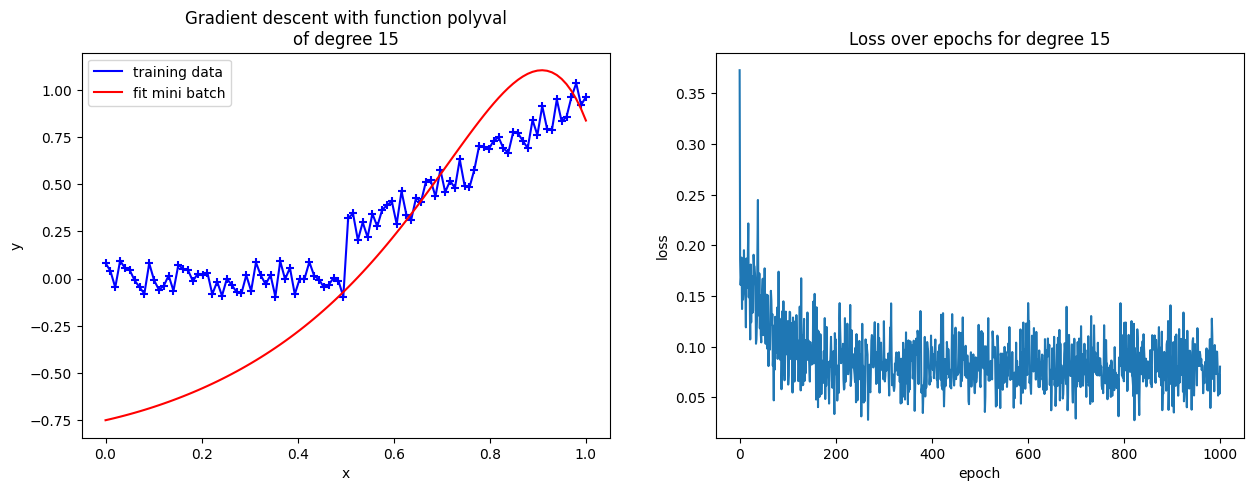

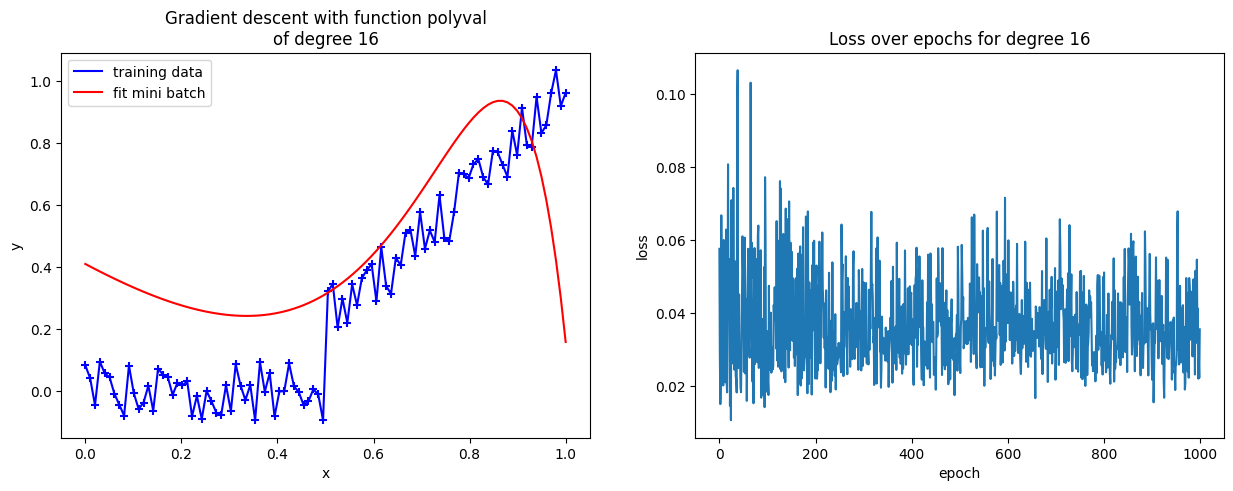

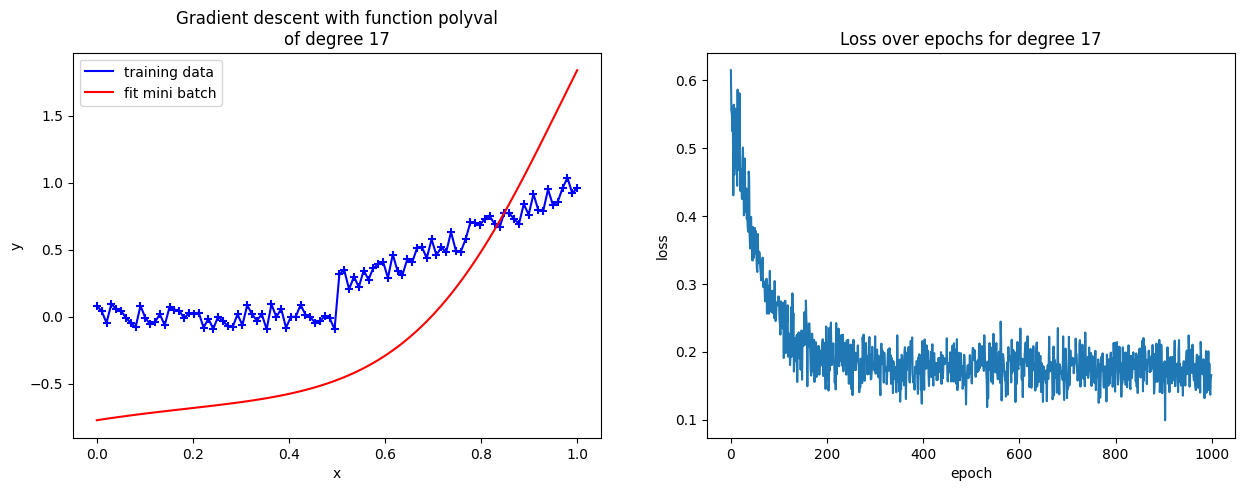

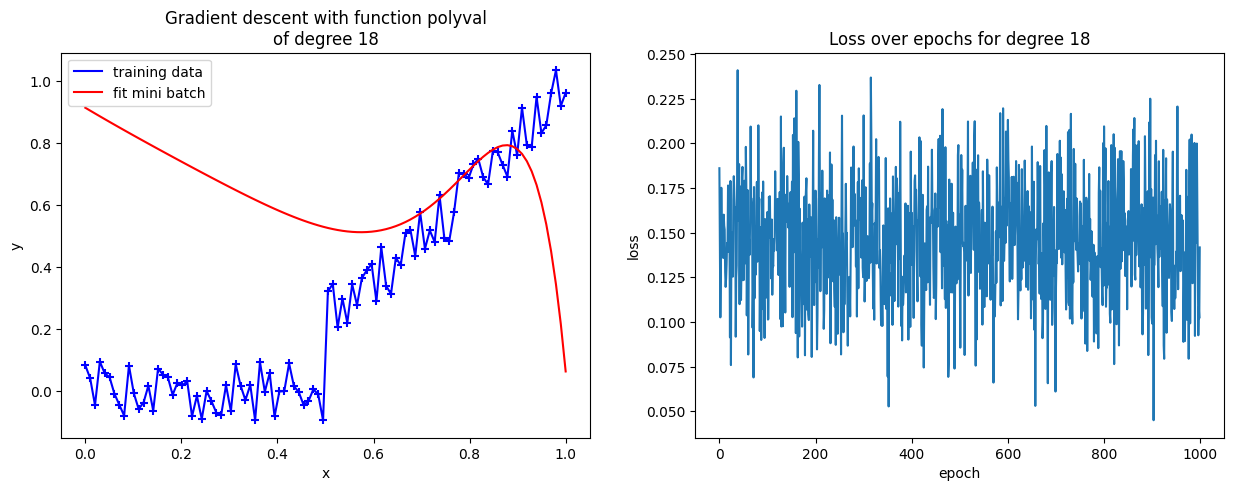

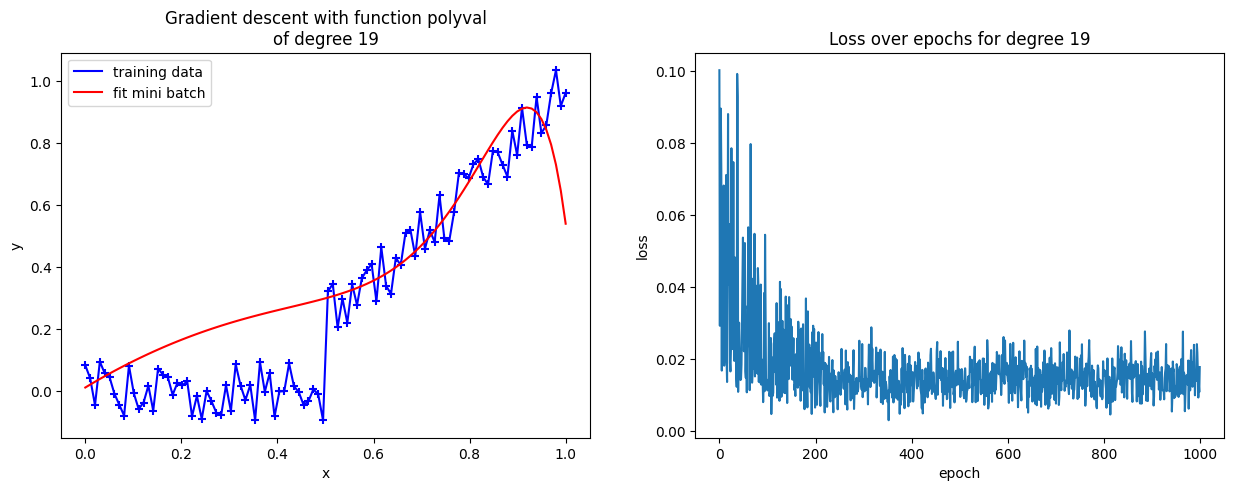

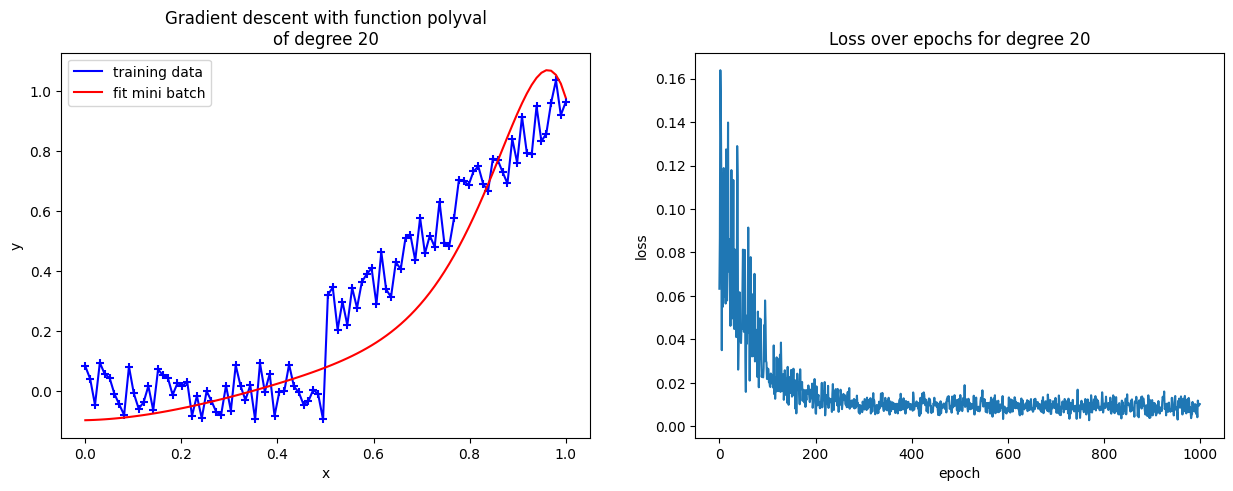

In [94]:
# generate dataset
x, y = generate_dataset(100, 0, 0.1)
results = []
for degree in range(21):
    mbgd = MiniBatchGradientDescent(
        learning_rate=1e-3, 
        batch_size=16,
        max_epochs=1000,
        tolerance=1e-3, 
        target_function=np.polyval, 
        degree=degree
        )
    mbgd.fit(x, y)
    mbgd.plot()
    loss = mbgd.get_training_loss()
    results.append({'degree': degree, 'loss': loss})
    
results = pd.DataFrame(results)

Text(0.5, 1.0, 'Loss vs. Degree')

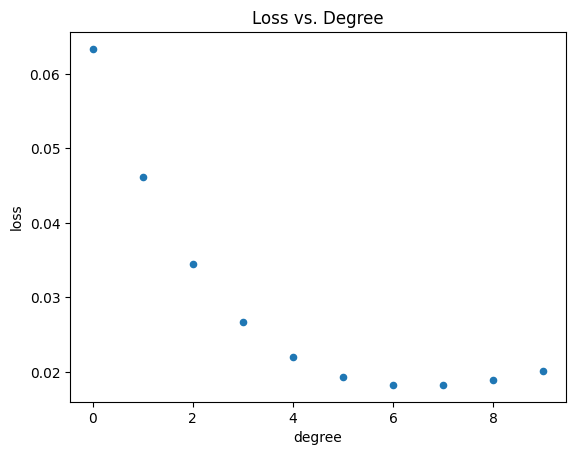

In [104]:
results.plot(x="degree", y="loss", kind="scatter")
plt.title("Loss vs. Degree")

### Mini Batch Gradient Descent

In [121]:
class MiniBatchGradientDescent(GradientDescent):
    # do i need something else here?
    def __init__(
        self,
        hypothesis_function: Callable,
        degree: int, 
        learning_rate: float, 
        num_iterations: int, 
        ) -> None:
        
        super().__init__(hypothesis_function, degree, learning_rate, num_iterations)
    
    def fit(self, x_data: NDArray, y_data: NDArray, batch_size: int) -> NDArray:
        """This method performs mini batch gradient descent with the given batch size."""
        self.x, self.y = x_data, y_data
        self.m = len(self.x)
        n_batches = int(self.m / batch_size)
        
        # perform gradient descent
        for i in range(self.num_iterations):
            for batch in self.iterate_minibatches(self.x, self.y, batch_size, shuffle=True):
                self.x_batch, self.y_batch = batch
                self.X_batch = np.vstack([self.x_batch**d for d in range(self.degree + 1)]).T
                h_batch = self.calculate_hypothesis(self.a_values, self.X_batch)
                self.loss[i] = self.calculate_loss(h_batch.mean(axis=1), self.y_batch, len(self.x_batch))
                gradient = self.calculate_gradient(h_batch, self.X_batch, len(self.x_batch), self.y_batch)
                # print(gradient.shape)
                gradient = gradient
                self.update_parameters(gradient)
        return self.a_values
    
    def calculate_loss(self, h: float | NDArray, y: NDArray, m: int) -> float | NDArray:
        return np.sum(np.mean((h - y[:, None])**2, axis=0)) / 2
    
    def calculate_gradient(self, h: float | NDArray, X: NDArray, m: int, y: NDArray) -> NDArray:
        y = y.reshape(-1, 1) # reshape y to (batch_size, 1)
        return np.array([np.sum((h - y) * X[:,i:i+1]) / m for i in range(self.degree + 1)])
    
    def iterate_minibatches(self, inputs, targets, batchsize, shuffle=False):
        assert len(inputs) == len(targets)
        if shuffle:
            indices = np.random.permutation(len(inputs))
        else:
            indices = np.arange(len(inputs))
        for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
            if shuffle:
                excerpt = indices[start_idx:start_idx + batchsize]
            else:
                excerpt = slice(start_idx, start_idx + batchsize)
            yield inputs[excerpt], targets[excerpt]


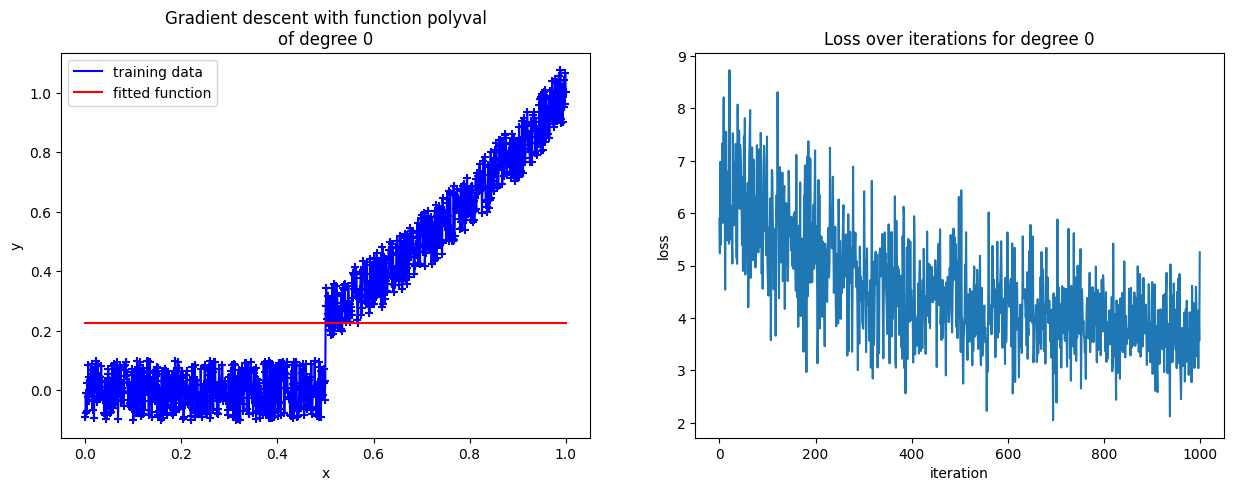

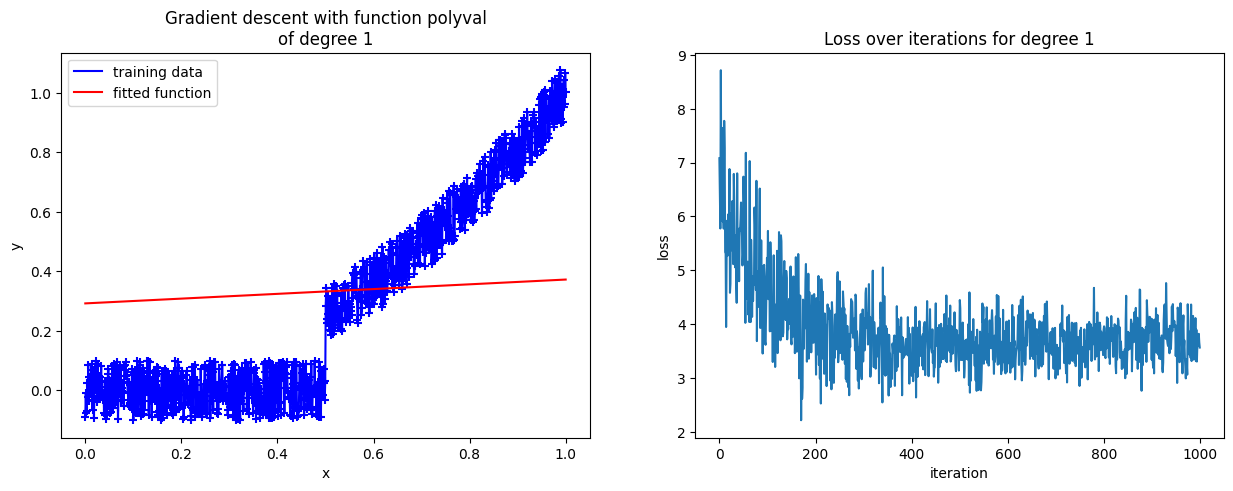

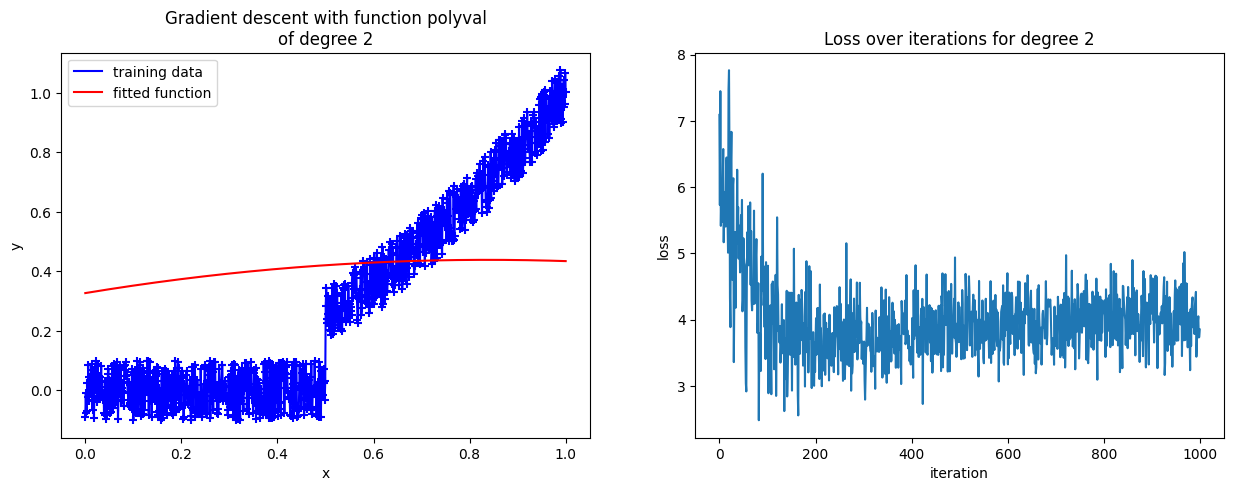

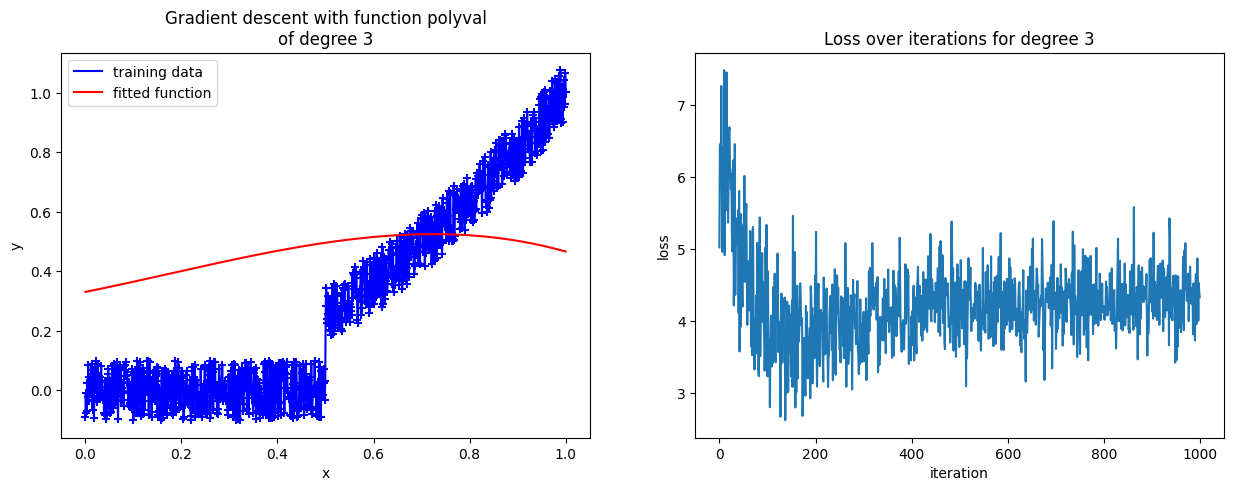

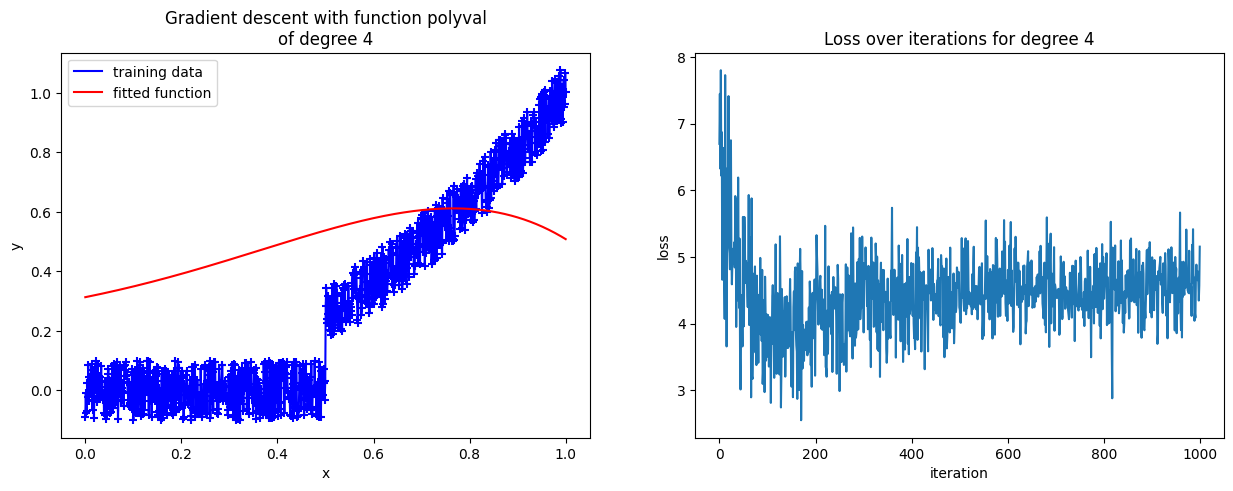

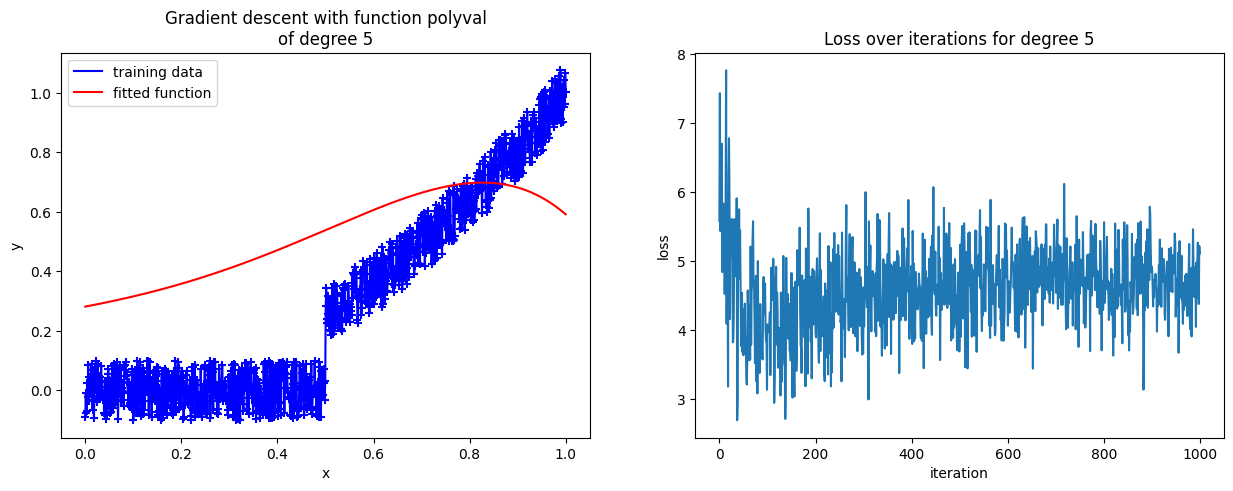

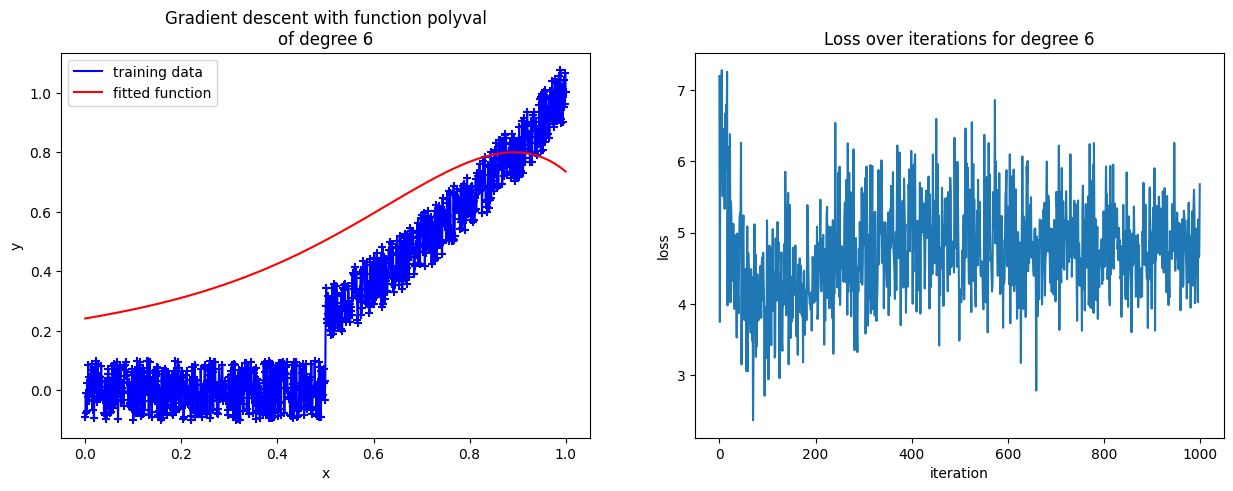

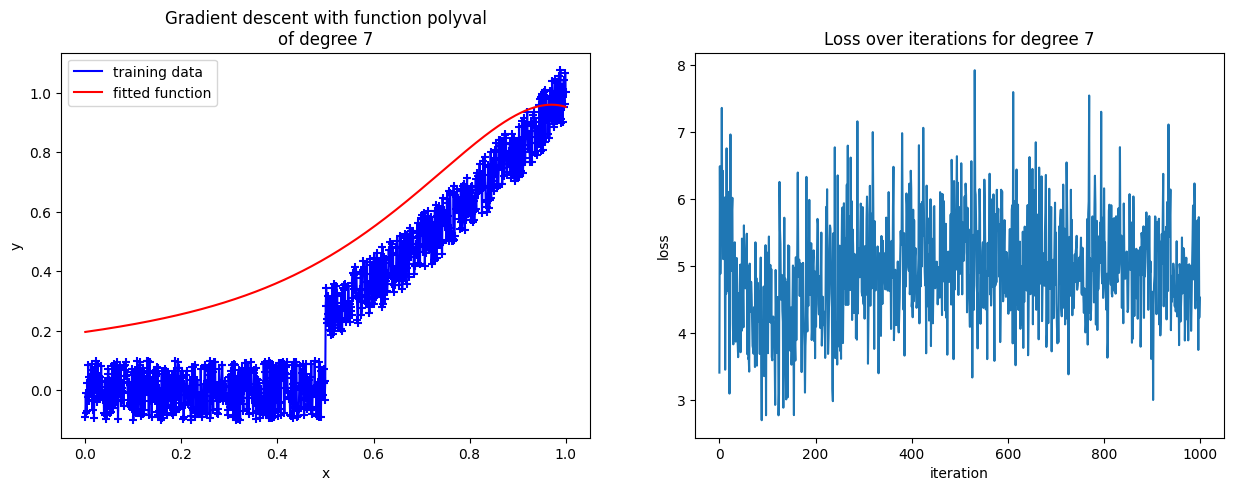

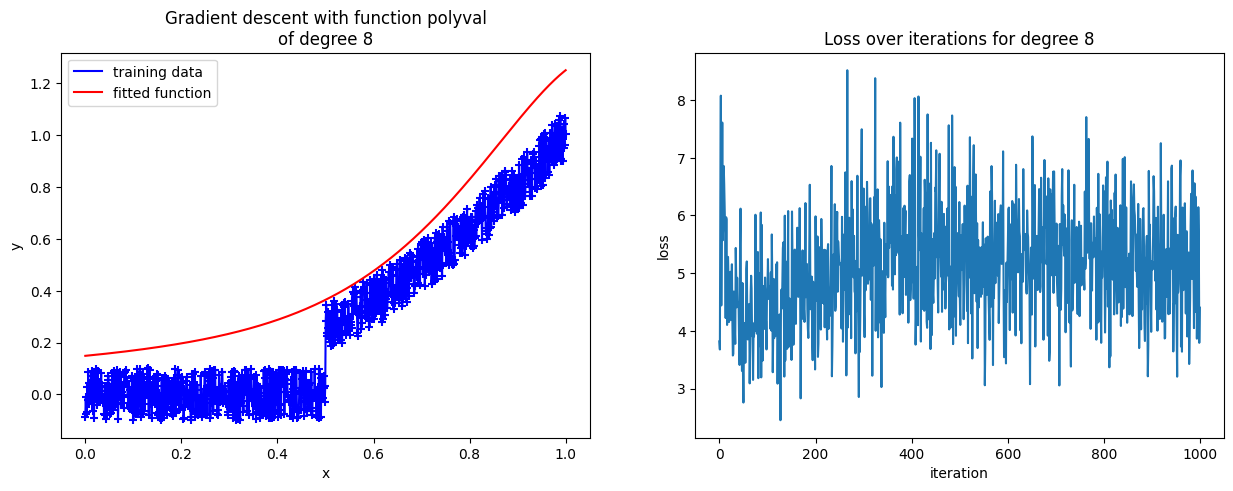

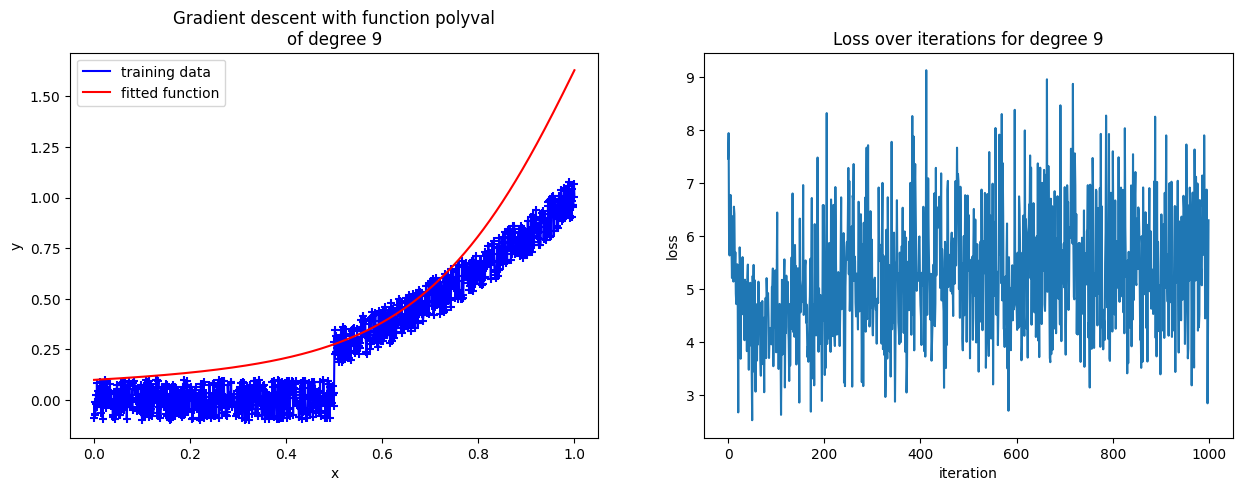

In [125]:
x, y = generate_dataset(1000, 0, 0.1)
results = []
degrees_to_test = range(0, 10)

for d in degrees_to_test:
    model = MiniBatchGradientDescent(hypothesis_function=np.polyval, degree=d, learning_rate=1e-4, num_iterations=1000)
    model.fit(x, y, batch_size=64)
    loss = model.get_training_loss()
    model.plot()
    results.append({"degree": d, "loss": loss})

results = pd.DataFrame(results)

Text(0.5, 1.0, 'Loss vs. Degree')

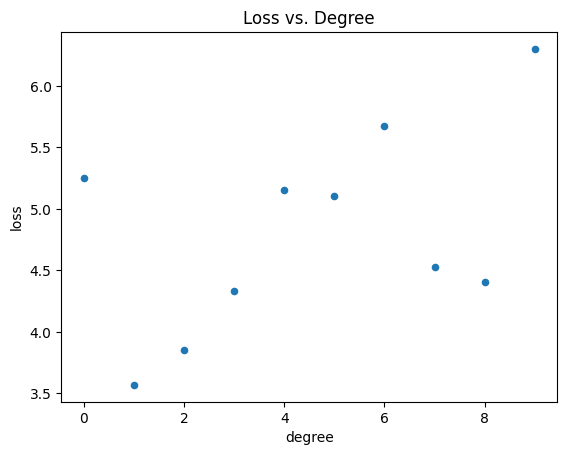

In [126]:
results.plot(x="degree", y="loss", kind="scatter")
plt.title("Loss vs. Degree")